Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [2]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from torchinfo import summary

In [3]:
batch_size = 256
#learning_rate = 1e-4
#num_epochs = 300

kernels = 32

prefix = f"fuzzy_classifier"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [4]:
def norm_and_transform(x):
    nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(nimg, -1, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, -1, 1)
    return nimg

train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomRotation(10), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)), 
    transforms.RandomCrop(size=26),
    transforms.Resize(size=(28, 28)),
    transforms.Lambda(norm_and_transform)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(norm_and_transform)
])


In [5]:
def get_target_and_mask(target_label):
    t = F.one_hot(torch.LongTensor([target_label]), 10)
    return t.squeeze().to(torch.float)

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = train_transform,
    #target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

len(train_data)

60000

загружаем тестовую выборку

In [6]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=test_transform, 
    #target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [7]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

torch.Size([256])


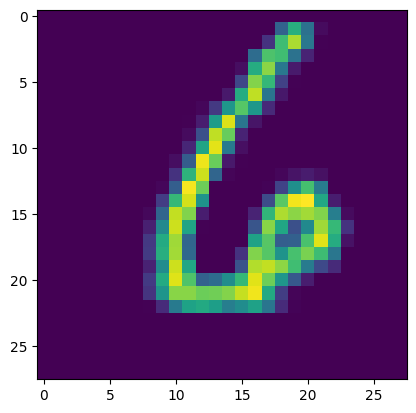

In [8]:
for data, t in iter(train_loader):
    plt.imshow(data[0].squeeze().cpu())
    print(t.shape)
    break

In [9]:


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)



In [10]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Модель

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) + (1 - out.sum(-1)).square().mean() # Calculate loss
        acc = accuracy(out, labels)  
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))

In [13]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.SiLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes, kernels):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 2*kernels)
        self.conv2 = conv_block(2*kernels, 4*kernels, pool=True)
        self.res1 = nn.Sequential(conv_block(4*kernels, 4*kernels), conv_block(4*kernels, 4*kernels))
        
        self.conv3 = conv_block(4*kernels, 8*kernels, pool=True)
        self.conv4 = conv_block(8*kernels, 16*kernels, pool=True)
        self.res2 = nn.Sequential(conv_block(16*kernels, 16*kernels), conv_block(16*kernels, 16*kernels))

        self.num_classes = num_classes
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                nn.Flatten(), 
                                nn.Dropout(0.2),
                                nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

## Обучение

In [14]:
model = ResNet9(1, 10, kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 6,574,218


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
  )
  (conv3): Sequential(
    (0): Co

In [15]:
inp = torch.rand(10, 1, 28, 28).to(device)
model(inp).shape

torch.Size([10, 10])

In [16]:


summary(model, input_size=(batch_size, 1, 28, 28))



Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [256, 10]                 --
├─Sequential: 1-1                        [256, 64, 28, 28]         --
│    └─Conv2d: 2-1                       [256, 64, 28, 28]         640
│    └─BatchNorm2d: 2-2                  [256, 64, 28, 28]         128
│    └─SiLU: 2-3                         [256, 64, 28, 28]         --
├─Sequential: 1-2                        [256, 128, 14, 14]        --
│    └─Conv2d: 2-4                       [256, 128, 28, 28]        73,856
│    └─BatchNorm2d: 2-5                  [256, 128, 28, 28]        256
│    └─SiLU: 2-6                         [256, 128, 28, 28]        --
│    └─MaxPool2d: 2-7                    [256, 128, 14, 14]        --
├─Sequential: 1-3                        [256, 128, 14, 14]        --
│    └─Sequential: 2-8                   [256, 128, 14, 14]        --
│    │    └─Conv2d: 3-1                  [256, 128, 14, 14]        147,584
│  

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, 
        grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    
    #sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in (range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        lrs=[]
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            if batch_idx % 60 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.4f}'.
                format(epoch+1, batch_idx , len(train_loader),
                       100. * batch_idx / len(train_loader), loss,accuracy))
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['lrs'] = lrs
        writer.add_scalars('ResNet9/Loss', 
                           {
                            'train_loss':result['train_loss'],
                            'test_loss':result['val_loss'],
        }, epoch)
        writer.add_scalars('ResNet9/Acc', 
                           {
                            'train_acc':result['train_accuracy'],
                            'test_acc':result['val_acc'],
        }, epoch)
        model.epoch_end(epoch, result)
        history.append(result)
        #sched.step()
    return history



In [23]:
evaluate(model, test_loader)

{'val_loss': 2.3039193153381348, 'val_acc': 0.10185547173023224}

In [24]:
epochs = 30
max_lr = 0.002
grad_clip = 0.12
weight_decay = 0.0001
opt_func = torch.optim.Adam(model.parameters(),max_lr, amsgrad=True, weight_decay=weight_decay)

In [25]:
history = fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/235 (0%)]	Loss: 12.472191, Accuracy: 0.0898
Train Epoch: 1 [60/235 (26%)]	Loss: 5.546015, Accuracy: 0.4609


In [ ]:
def plot_accuracies(history):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title('Accuracy vs. No. of epochs')

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

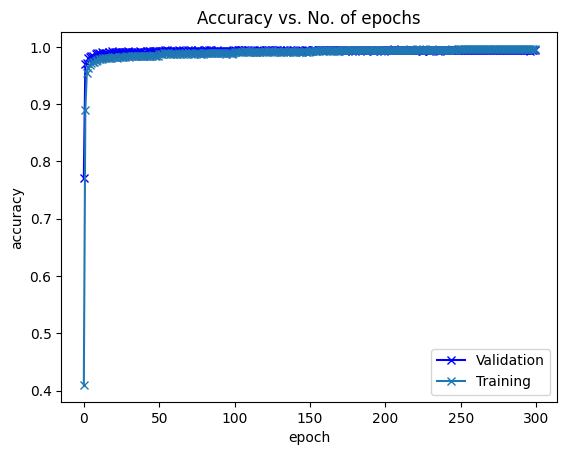

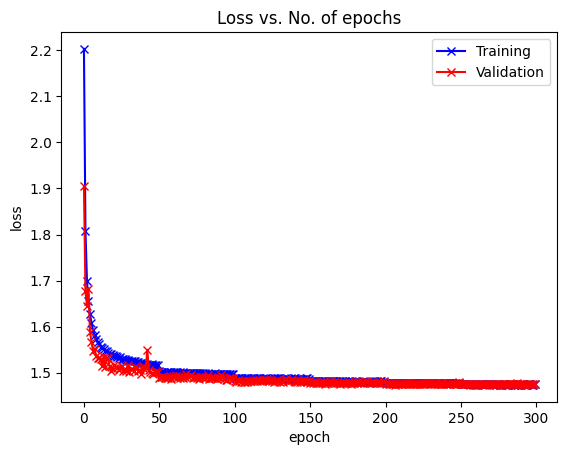

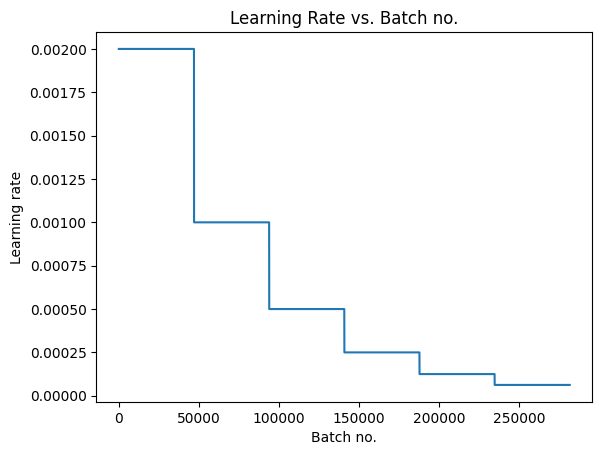

In [ ]:
plot_accuracies(history)
plt.show()
plot_losses(history)
plt.show()
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_data.classes[preds[0].item()]

Label: 4 - four , Predicted: 4 - four


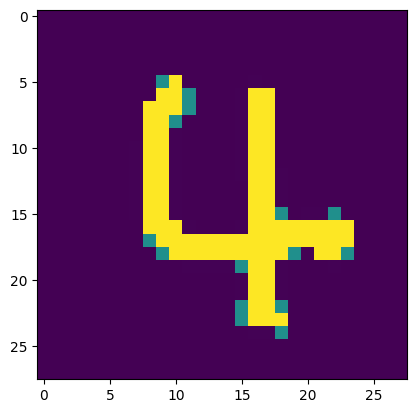

In [ ]:
img, label = test_data[1023]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_data.classes[label], ', Predicted:', predict_image(img, model))